In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%precision 4
%reload_ext autoreload
# Load the TensorBoard notebook extension.
%load_ext tensorboard

import re
import sys
import math
import random
import os
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
import warnings


warnings.filterwarnings(action='once')
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = None
sns.set(style="whitegrid")

from IPython.core.pylabtools import figsize
figsize(20, 7)

### Target

Item sales for the month immediately after the data in sales_train.csv, which is November 2015:

DAILY_SALES=pd.read_csv('sales_train.csv')
DAILY_SALES['date_dt']=pd.to_datetime(DAILY_SALES['date'],format="%d.%m.%Y")
print(DAILY_SALES.date_dt.max())
> Timestamp('2015-10-31 00:00:00')

You want to predict the total sales for that month, i.e. one number for each shop/item pair in the test.csv file.

In [2]:
from pathlib import Path


BASE_DIR = Path("../input/predict_future_sales/")
print(os.listdir(BASE_DIR))

['item_categories.csv', 'items.csv', 'sales_train.csv', 'sample_submission.csv', 'shops.csv', 'test.csv']


In [3]:
items  = pd.read_csv(BASE_DIR / 'items.csv')
train = pd.read_csv(BASE_DIR / 'sales_train.csv')
test = pd.read_csv(BASE_DIR / 'test.csv')
item_category = pd.read_csv(BASE_DIR / 'item_categories.csv')
shops = pd.read_csv(BASE_DIR / 'shops.csv')

In [4]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
train['date'].min(), train['date'].max()

('01.01.2013', '31.12.2014')

In [7]:
train[(train.item_price < 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [8]:
# -1 and 307980 looks like outliers, let's delete them
print('before train shape:', train.shape)
train = train[(train.item_price > 0)]
print('after train shape:', train.shape)

before train shape: (2935849, 6)
after train shape: (2935848, 6)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb45401ef0>]],
      dtype=object)

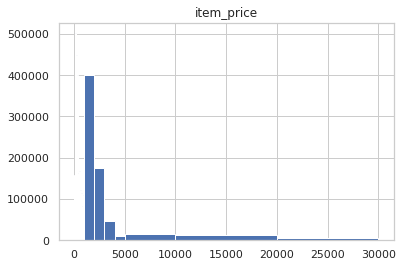

In [9]:
train[['item_price']].hist(bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000])

In [10]:
train['item_price_log1p'] = train.apply(lambda x: np.log1p(x['item_price']), axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb453032e8>,
      dtype=object)

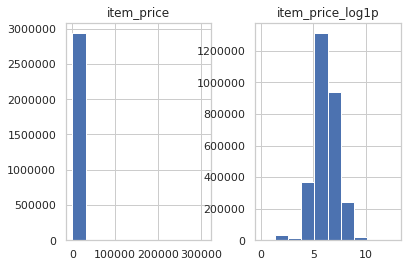

In [11]:
train[['item_price', 'item_price_log1p']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb44c58470>,
      dtype=object)

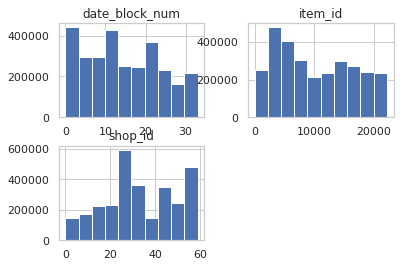

In [12]:
train[['date_block_num', 'shop_id', 'item_id']].hist()

In [13]:
item_category.head()

sum(item_category['item_category_id'].duplicated())

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


0

In [14]:
items.head()

sum(items['item_id'].duplicated())

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


0

In [15]:
item_to_cat_df = pd.merge(items, item_category, how="left", on="item_category_id")
item_to_cat_df.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76,Программы - Для дома и офиса (Цифра)
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD


In [16]:
train['date'] = pd.to_datetime(train.date,format="%d.%m.%Y")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_price_log1p
0,2013-01-02,0,59,22154,999.00,1.0,6.907755
1,2013-01-03,0,25,2552,899.00,1.0,6.802395
2,2013-01-05,0,25,2552,899.00,-1.0,6.802395
3,2013-01-06,0,25,2554,1709.05,1.0,7.444278
4,2013-01-15,0,25,2555,1099.00,1.0,7.003065


### Trend

In [17]:
## Pivot by monht to wide format
p_df = train.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
p_df.head()

date_block_num     0     1    2    3    4    5    6    7    8    9   10   11  \
shop_id item_id                                                                
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        33       3.0  3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

date_block_num    12   13   14   15   16   17   18   19   20   21   22   23  \
shop_id item_id                                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

date_block_num    24   25   26   27   28   29   30   31   32   33  
shop_id item_id                                                    
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [18]:
## Join with categories
p_df = p_df.reset_index()
# train_cleaned_df['shop_id']= train_cleaned_df.shop_id.astype('str')
# train_cleaned_df['item_id']= train_cleaned_df.item_id.astype('str')

# item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

p_df = p_df.merge(item_to_cat_df, how="inner", on="item_id")
p_df.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_name,item_category_id,item_category_name
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD


In [19]:
# Encode Categories
from sklearn import preprocessing


p_df.columns = p_df.columns.astype(str)

number = preprocessing.LabelEncoder()
p_df['cats'] = p_df.item_category_name
p_df[['cats']] = number.fit_transform(p_df.cats)
p_df.head()

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_name,item_category_id,item_category_name,cats
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb6622b518>,
      dtype=object)

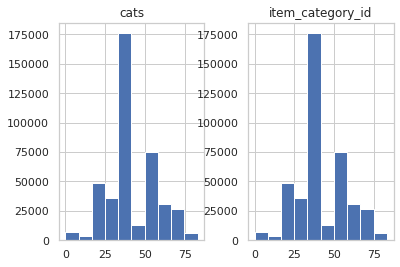

In [20]:
p_df[['cats', 'item_category_id']].hist()

In [21]:
p_df[p_df['33']<0].head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_name,item_category_id,item_category_name,cats
149105,48,2860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,-1.0,"Disney. Infinity 2.0 (Marvel). Набор ""2+1"": ""Стражи Галактики"" (Звёздный лорд, Гамора, Локация ""Стра",25,Игры - Аксессуары для игр,25
183156,34,7233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,-1.0,"Universal: Кабель HDMI Hori высокоскоростной, 2 м, 3D, 1080p, черный (HP3-165)",3,Аксессуары - PS4,3
193535,12,9242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,9.0,904.0,697.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,"Билет ""ИгроМир 2014"" (на один день (отдельно - 4, 5 октября 2014))",8,Билеты (Цифра),8
200518,26,10513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,ГРАНЬ БУДУЩЕГО (3D BD+BD) железный бокс,38,Кино - Blu-Ray 3D,38
258525,26,21363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,ХОББИТ. ТРИЛОГИЯ (6 REAL 3D BD+6 BD),41,Кино - Коллекционное,41


### y
- y is skew
- y has one record with very large value

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fb40bf588>]],
      dtype=object)

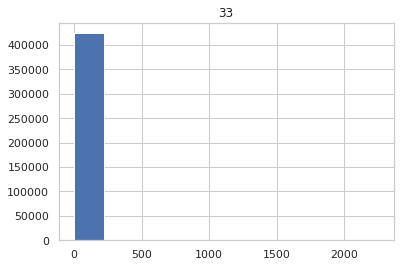

In [48]:
p_df[['33']].hist()

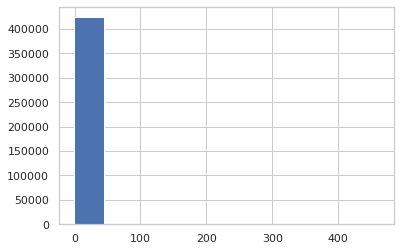

In [49]:
p_df[p_df['33'] < 500]['33'].hist()

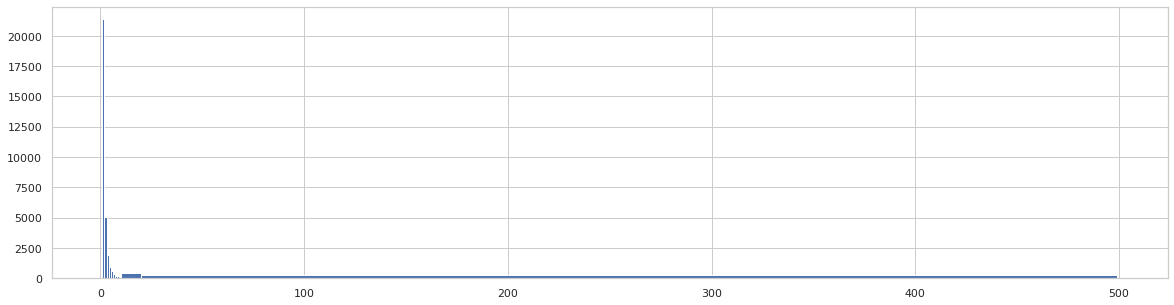

In [53]:
p_df['33'].hist(bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 499], figsize=(20, 5))

In [54]:
import seaborn as sns

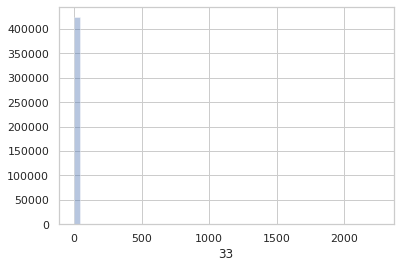

In [58]:
sns.distplot(p_df['33'], kde=False)

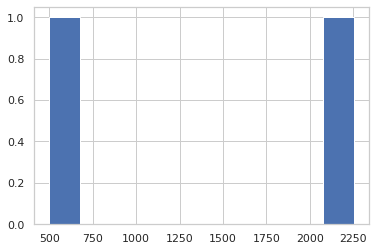

In [52]:
p_df[p_df['33'] >= 500]['33'].hist()

In [46]:
len(p_df)

df_without_gt_500 = p_df[p_df['33'] < 500]
df_without_gt_500.head()

len(df_without_gt_500)

424124

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_name,item_category_id,item_category_name,cats
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40


424122

### Outlier?

In [65]:
p_df[p_df['33'] < 500].sort_values(by='33', ascending=False).head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_name,item_category_id,item_category_name,cats
257995,25,20949,0.0,0.0,0.0,5.0,83.0,766.0,575.0,607.0,764.0,764.0,795.0,1066.0,237.0,192.0,107.0,107.0,302.0,771.0,563.0,533.0,507.0,491.0,588.0,997.0,580.0,0.0,0.0,476.0,498.0,444.0,353.0,323.0,388.0,461.0,Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71
258012,42,20949,0.0,0.0,0.0,2.0,23.0,453.0,311.0,374.0,421.0,380.0,370.0,570.0,384.0,169.0,420.0,304.0,256.0,249.0,323.0,335.0,384.0,407.0,459.0,687.0,365.0,257.0,0.0,378.0,347.0,316.0,369.0,368.0,387.0,446.0,Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71
258001,31,20949,0.0,0.0,0.0,13.0,384.0,763.0,799.0,820.0,950.0,978.0,989.0,1305.0,899.0,941.0,776.0,597.0,602.0,625.0,528.0,591.0,639.0,634.0,772.0,1209.0,743.0,180.0,0.0,481.0,460.0,434.0,482.0,436.0,473.0,431.0,Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71
257998,28,20949,0.0,0.0,0.0,7.0,504.0,634.0,540.0,641.0,584.0,430.0,568.0,759.0,552.0,500.0,530.0,444.0,441.0,579.0,423.0,493.0,415.0,422.0,498.0,739.0,627.0,45.0,77.0,320.0,309.0,328.0,299.0,284.0,237.0,229.0,Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71
400015,9,4201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,194.0,Kaspersky Internet Security для Android Russian Edition. 1 Device 1 year Base Card,75,Программы - Для дома и офиса,75


In [47]:
p_df[p_df['33'] >= 500]

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_name,item_category_id,item_category_name,cats
257984,12,20949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71
404791,12,11373,6.0,2.0,21.0,9.0,7.0,28.0,9.0,39.0,33.0,51.0,373.0,77.0,46.0,183.0,203.0,61.0,147.0,50.0,32.0,39.0,98.0,68.0,308.0,265.0,133.0,117.0,147.0,292.0,742.0,202.0,201.0,75.0,246.0,2253.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,9


In [41]:
drop_33_gt_500 = p_df[p_df['33'] < 500]

### Assign X and y

In [22]:
df = p_df

X_cols = ['shop_id', 'item_id', 'item_category_id'] + [str(i) for i in range(33)]
y_col = ['33']

X = df[X_cols].values
y = df[y_col].values.reshape(-1)

In [23]:
df[X_cols].head()

,shop_id,item_id,item_category_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0,30,40,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,40,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,40,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,40,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,30,40,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### XGBoost

https://xgboost.readthedocs.io/en/latest/python/python_intro.html

In [42]:
from sklearn.metrics import mean_squared_error 
from sklearn import metrics
from sklearn.model_selection import cross_val_score


import xgboost as xgb
param = {'max_depth':40, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}
bst = xgb.XGBRegressor(**param)

In [36]:
bst.fit(X, y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.300000012,
             max_delta_step=0, max_depth=40, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, num_round=1000, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=1, silent=0, subsample=1, tree_method=None, ...)

In [43]:
cross_val_score(bst, X, y, cv=5)

array([  0.1815,  -1.7807,   0.1102, -24.3836,   0.0346])

In [39]:
preds  = bst.predict(X)
rmse = np.sqrt(mean_squared_error(preds, y))
rmse

0.0011278208529175088

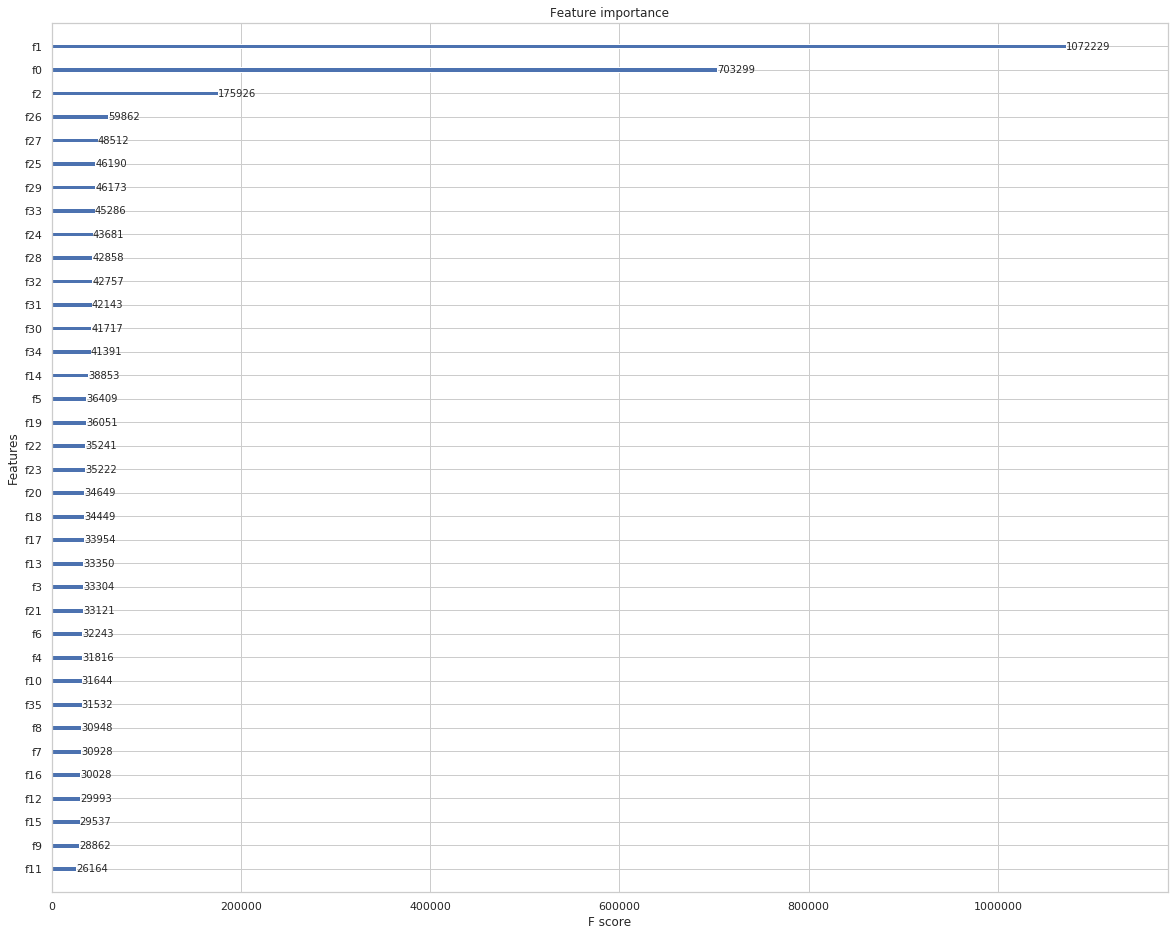

In [40]:
fig = plt.figure(figsize=(20, 16)) 
ax = fig.add_subplot() 

xgb.plot_importance(bst, ax=ax)

### Random Forest

In [78]:
from sklearn.ensemble import RandomForestRegressor


r_model = RandomForestRegressor(max_depth=60, random_state=0)

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [79]:
cross_val_score(r_model, X, y, cv=5)

/usr/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_est

array([ 0.3539, -0.8458,  0.1636, -5.7455,  0.0856])

In [80]:
r_model.fit(X, y)

r_p_y = r_model.predict(X)
rmse = np.sqrt(metrics.mean_squared_error(y, r_p_y))
rmse

/usr/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


nan

### Auto Sklearn

In [ ]:
# Solved by restarting the ipython kernel.
# https://www.simonwenkel.com/2018/09/09/Introduction-to-auto-sklearn.html

# Doc
# https://automl.github.io/auto-sklearn/master/api.html

In [24]:
from ktool import models

In [25]:
from autosklearn import regression
import autosklearn
from autosklearn import metrics


feature_types = (['categorical'] * 3) + (['numerical'] * 33)

model = regression.AutoSklearnRegressor(
            time_left_for_this_task=3600,
            per_run_time_limit=60 * 100,
            tmp_folder='./tmp',
            output_folder='./output',
            delete_tmp_folder_after_terminate=True,
            #resampling_strategy='cv',
            #resampling_strategy_arguments={'folds': 5},
            ml_memory_limit=3072*50,
            include_estimators=["random_forest", "xgradient_boosting"],
            # {'cv': {‘folds’: 10}}
        )


model.fit(X, y, feat_type=feature_types, metric=models.root_mean_squared_error)

[WARNING] [2020-03-12 16:57:10,842:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 16:57:10,862:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (3599.023250)
[WARNING] [2020-03-12 16:57:10,869:AutoMLSMBO(1)::5c6c753f364e044aae1578f102b5c99b] Could not find meta-data directory /usr/lib64/python3.6/site-packages/autosklearn/metalearning/files/root_mean_squared_error_regression_dense
[WARNING] [2020-03-12 16:57:12,870:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 16:57:14,876:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 16:57:16,885:EnsembleBuilder(1):5c6c753f364e044aae1578f102

[WARNING] [2020-03-12 16:59:03,196:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 16:59:05,202:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 16:59:07,207:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 16:59:09,214:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 16:59:11,219:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 16:59:13,226:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 16:59:15,232:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 16:59:17,238

[WARNING] [2020-03-12 17:01:03,553:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:01:05,559:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:01:07,565:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:01:09,571:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:01:11,577:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:01:13,583:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:01:15,589:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:01:17,596

[WARNING] [2020-03-12 17:03:03,902:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:03:05,909:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:03:07,914:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:03:09,920:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:03:11,926:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:03:13,932:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:03:15,938:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:03:17,944

[WARNING] [2020-03-12 17:05:04,260:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:05:06,265:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:05:08,270:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:05:10,276:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:05:12,282:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:05:14,288:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:05:16,294:EnsembleBuilder(1):5c6c753f364e044aae1578f102b5c99b] No models better than random - using Dummy Score!
[WARNING] [2020-03-12 17:05:18,300

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


AutoSklearnRegressor(delete_output_folder_after_terminate=True,
                     delete_tmp_folder_after_terminate=True,
                     disable_evaluator_output=False, ensemble_memory_limit=1024,
                     ensemble_nbest=50, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None,
                     include_estimators=['random_forest', 'xgradient_boosting'],
                     include_preprocessors=None,
                     initial_configurations_via_metalearning=25,
                     logging_config=None, metadata_directory=None,
                     ml_memory_limit=153600, n_jobs=None,
                     output_folder='./output', per_run_time_limit=6000,
                     resampling_strategy='holdout',
                     resampling_strategy_arguments=None, seed=1,
                     shared_mode=False, smac_scenario_args=None,
                     time_left_for_t

In [26]:
from sklearn.metrics import mean_squared_error 
preds = model.predict(X)
rmse = np.sqrt(mean_squared_error(preds, y))
print(rmse)

3.1195282154436277


In [27]:
model.get_params()

{'delete_output_folder_after_terminate': True,
 'delete_tmp_folder_after_terminate': True,
 'disable_evaluator_output': False,
 'ensemble_memory_limit': 1024,
 'ensemble_nbest': 50,
 'ensemble_size': 50,
 'exclude_estimators': None,
 'exclude_preprocessors': None,
 'get_smac_object_callback': None,
 'include_estimators': ['random_forest', 'xgradient_boosting'],
 'include_preprocessors': None,
 'initial_configurations_via_metalearning': 25,
 'logging_config': None,
 'metadata_directory': None,
 'ml_memory_limit': 153600,
 'n_jobs': None,
 'output_folder': './output',
 'per_run_time_limit': 6000,
 'resampling_strategy': 'holdout',
 'resampling_strategy_arguments': None,
 'seed': 1,
 'shared_mode': False,
 'smac_scenario_args': None,
 'time_left_for_this_task': 3600,
 'tmp_folder': './tmp'}

In [28]:
model.get_models_with_weights()

[(0.64,
  SimpleRegressionPipeline({'categorical_encoding:__choice__': 'one_hot_encoding', 'imputation:strategy': 'mean', 'preprocessor:__choice__': 'feature_agglomeration', 'regressor:__choice__': 'random_forest', 'rescaling:__choice__': 'quantile_transformer', 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'True', 'preprocessor:feature_agglomeration:affinity': 'cosine', 'preprocessor:feature_agglomeration:linkage': 'complete', 'preprocessor:feature_agglomeration:n_clusters': 272, 'preprocessor:feature_agglomeration:pooling_func': 'mean', 'regressor:random_forest:bootstrap': 'True', 'regressor:random_forest:criterion': 'friedman_mse', 'regressor:random_forest:max_depth': 'None', 'regressor:random_forest:max_features': 0.43140730352893497, 'regressor:random_forest:max_leaf_nodes': 'None', 'regressor:random_forest:min_impurity_decrease': 0.0, 'regressor:random_forest:min_samples_leaf': 4, 'regressor:random_forest:min_samples_split': 6, 'regressor:random_forest:min_weight_

### Evaluation

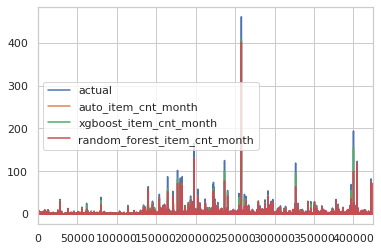

In [174]:
eva_df = pd.DataFrame({
    'actual':df['33'],
    'auto_item_cnt_month': model.predict(X), 
    'xgboost_item_cnt_month': bst.predict(xgb.DMatrix(X, feature_names=X_cols)),
    'random_forest_item_cnt_month': r_p_y
})
eva_df.plot()

[WARNING] [2020-03-10 18:08:34,850:matplotlib.axes._axes] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


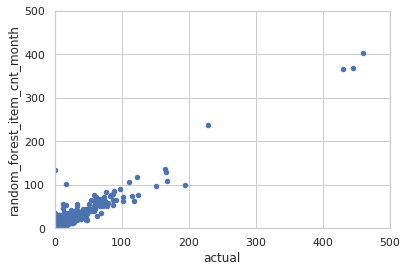

In [157]:
eva_df.plot.scatter(x='actual', y='random_forest_item_cnt_month', ylim=(0, 500), xlim=(0, 500))

[WARNING] [2020-03-10 18:08:39,297:matplotlib.axes._axes] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


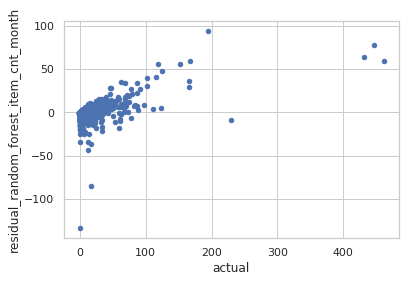

In [158]:
eva_df['residual_random_forest_item_cnt_month'] = eva_df['actual'] - eva_df['random_forest_item_cnt_month']

eva_df.plot.scatter(x='actual', y='residual_random_forest_item_cnt_month')

[WARNING] [2020-03-10 18:23:45,392:matplotlib.axes._axes] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


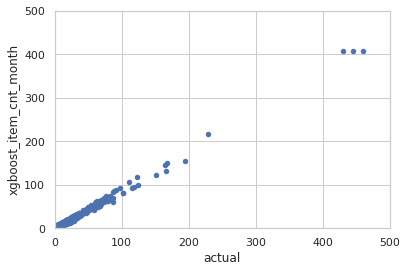

In [176]:
eva_df.plot.scatter(x='actual', y='xgboost_item_cnt_month', ylim=(0, 500), xlim=(0, 500))

[WARNING] [2020-03-10 18:23:08,794:matplotlib.axes._axes] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


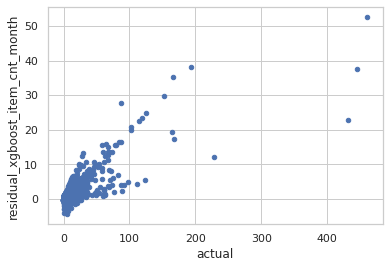

In [175]:
eva_df['residual_xgboost_item_cnt_month'] = eva_df['actual'] - eva_df['xgboost_item_cnt_month']

eva_df.plot.scatter(x='actual', y='residual_xgboost_item_cnt_month')

In [ ]:
sns.residplot('xgboost_item_cnt_month', 'actual', lowess=True, data=eva_df)

### Prediction Test

In [159]:
test_df = pd.merge(test, p_df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
test_df.head()

,ID,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_name,item_category_id,item_category_name,cats
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,"NHL 15 [PS3, русские субтитры]",19.0,Игры - PS3,19.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,"Need for Speed Rivals (Essentials) [PS3, русская версия]",19.0,Игры - PS3,19.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, русская версия]",23.0,Игры - XBOX 360,23.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0


### Output

In [179]:
sub_df = pd.DataFrame(
    {'ID':test_df.ID,
     'auto_item_cnt_month': model.predict(test_df[X_cols].values), 
     'xgb_item_cnt_month': bst.predict(xgb.DMatrix(test_df[X_cols].values, feature_names=X_cols)),
     'random_item_cnt_month': r_model.predict(test_df[X_cols].values)})
sub_df['auto_item_cnt_month'] = sub_df.apply(lambda x: int(min(20,max(x['auto_item_cnt_month'],0))), axis=1)
sub_df['xgb_item_cnt_month'] = sub_df.apply(lambda x: int(min(20,max(x['xgb_item_cnt_month'],0))), axis=1)
sub_df['random_item_cnt_month'] = sub_df.apply(lambda x: int(min(20,max(x['random_item_cnt_month'],0))), axis=1)

sub_df.describe()

,ID,auto_item_cnt_month,xgb_item_cnt_month,random_item_cnt_month
count,214200.000000,214200.0,214200.000000,214200.000000
mean,107099.500000,0.0,0.134566,0.171102
std,61834.358168,0.0,0.941581,0.984227
min,0.000000,0.0,0.000000,0.000000
25%,53549.750000,0.0,0.000000,0.000000
50%,107099.500000,0.0,0.000000,0.000000
75%,160649.250000,0.0,0.000000,0.000000
max,214199.000000,0.0,20.000000,20.000000


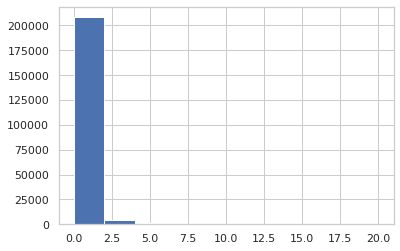

In [162]:
sub_df['random_item_cnt_month'].hist()

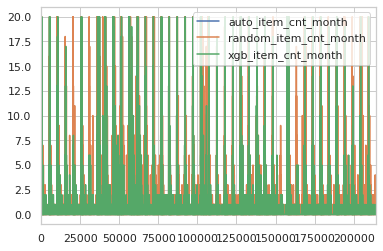

In [64]:
sub_df[['auto_item_cnt_month', 'random_item_cnt_month', 'xgb_item_cnt_month']].plot()

In [180]:
output_column = 'xgb_item_cnt_month'
output_file_path = '../output/Submission_Predict Sales.csv'


sub_df['item_cnt_month'] = sub_df[output_column]
sub_df[['ID', 'item_cnt_month']].to_csv(output_file_path, index=False)